In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 19.1 - Object Tracking Example

## Objectives

+ Demonstrate the filtering problem in the context of object tracking

Consider an object of mass $m$ and position vector $\vec{r} = r_x\hat{i}+r_y\hat{j}$,
where $\hat{i}$ and $\hat{j}$ are the unit vectors in the x- and y-direction, respectively.
As we saw in the lecture video, the dynamics are given by Newton's law:
$$
m\frac{d^2\vec{r}}{dt^2} = \vec{F} = u_x\hat{i} + u_y\hat{j}.
$$

We also saw that these 2nd order differential equations can be written as four first order differential equations:
$$
\frac{d\vec{r}}{dt} = \vec{v},
$$
and
$$
\frac{d\vec{v}}{dt} = \frac{u_x}{m}\hat{i} + \frac{u_y}{m}\hat{j}.
$$

Then, we used the Euler scheme with a timestep $\Delta t$ to numerically solve these equations, yielding:
$$
\vec{r}((n+1)\Delta t) = \vec{r}(n\Delta t) + \Delta t\vec{v}(n\Delta t),
$$
and
$$
\vec{v}((n+1)\Delta t) = \vec{v}(n\Delta t) + \Delta t\left(u_x\hat{i} + u_y\hat{j}\right).
$$

Writing the state vector as:
$$
\mathbf{x}_n =
\begin{bmatrix}
r_x(n\Delta t)\\
r_y(n\Delta t)\\
v_x(n\Delta t)
\end{bmatrix},
$$
and the control vector as:
$$
\mathbf{u}_n =
\begin{bmatrix}
u_x(n\Delta t)\\
u_y(n\Delta t)
\end{bmatrix},
$$
then we see that the system satisfies the linear transition equation:
$$
\mathbf{x}_{n+1} = \mathbf{A}\mathbf{x}_n + \mathbf{B}\mathbf{u}_n + \mathbf{z}_n,
$$
with transition matrix:
$$
\mathbf{A} =
\begin{bmatrix}
1 & 0 & \Delta t & 0\\
0 & 1 & 0 & \Delta t\\
0 & 0 & 1 & 0\\
0 & 0 & 0 & 1
\end{bmatrix},
$$
control matrix:
$$
\mathbf{B} = \begin{bmatrix}
0 & 0\\
0 & 0\\
\frac{\Delta t}{m} & 0\\
0 & \frac{\Delta t}{m}
\end{bmatrix}
$$
and we assume that
$$
\mathbf{z}_n \sim N(\mathbf{0},\mathbf{Q}),
$$
is some process noise with covariance matrix $\mathbf{Q}$.
Notice that the process noise does not appear in the original system.
We have included it by hand and it is a modeling choice.
We take the process covariance matrix to be:
$$
Q = \begin{bmatrix}
\epsilon & 0 & 0 & 0\\
0 & \epsilon & 0 & 0\\
0 & 0 & \sigma^2_q & 0\\
0 & 0 & 0 & \sigma^2_q
\end{bmatrix},
$$
where we have included a small $\epsilon>0$ is very small and captures the discretization error of the Euler scheme.
The variance $\sigma_q^2$ can be larger as it captures both the discretization error and any external forces to the system (forces that are not captured in $\mathbf{u}_n$).

Now let's talk about the measurements.
Let's assume that we measure a noisy version of the position of the object.
This is typically of GPS measurements.
Mathematically, we have:
$$
\mathbf{y}_n = \mathbf{C}\mathbf{x}_n + \mathbf{w}_n,
$$
with
$$
C = \begin{bmatrix}
1 & 0 & 0 & 0\\
0 & 1 & 0 & 0
\end{bmatrix}
$$
with measurement covariance:
$$
R =
\begin{bmatrix}
\sigma_r^2 & 0 \\
0 & \sigma_r^2
\end{bmatrix}.
$$
This is it.
Now, let's define all the necessary quantities:

In [2]:
# The timestep
Dt = 0.5
# The mass
m = 1.0
# The variance for the process noise for position
epsilon = 1e-6
# The standard deviation for the process noise for velocity
sigma_q = 1e-2
# The standard deviation for the measurement noise for position
sigma_r = 0.1

# INITIAL CONDITIONS
# initial mean
mu0 = np.zeros((4,))
# initial covariance
V0 = np.array([0.1**2, 0.1**2, 0.1**2, 0.1**2]) * np.eye(4)

# TRANSITION MATRIX
A = np.array([[1.0, 0, Dt, 0],
              [0.0, 1.0, 0.0, Dt],
              [0.0, 0.0, 1.0, 0.0],
              [0.0, 0.0, 0.0, 1.0]])
# CONTROL MATRIX
B = np.array([[0.0, 0.0],
              [0.0, 0.0],
              [Dt / m, 0.0],
              [0.0, Dt / m]])
# PROCESS COVARIANCE
Q = np.array([epsilon, epsilon, sigma_q ** 2, sigma_q ** 2]) * np.eye(4)
# EMISSION MATRIX
C = np.array([[1.0, 0.0, 0.0, 0.0],
               [0.0, 1.0, 0.0, 0.0]])
# MEASUREMENT COVARIANCE
R = np.array([sigma_r ** 2, sigma_r ** 2]) * np.eye(2)

Now we are going to simulate a trajectory of this particle.

In [3]:
# The number of steps in the trajectory
num_steps = 50
# Space to store the trajectory (each state is 4-dimensional)
true_trajectory = np.ndarray((num_steps + 1, 4))
# Space to store the observations (each observation is 2-dimensional)
observations = np.ndarray((num_steps, 2))

# Sample the initial conditions
x0 = mu0 + np.sqrt(np.diag(V0)) * np.random.randn(4)
true_trajectory[0] = x0

# Pick a set of pre-determined forces to be applied to the object
# so that it does something interesting
force = .1
omega = 2.0 * np.pi / 5
times = Dt * np.arange(num_steps + 1)
us = np.zeros((num_steps, 2))
us[:, 0] = force * np.cos(omega * times[1:])
us[:, 1] = force * np.sin(omega * times[1:])

# Sample the trajectory
for n in range(num_steps):
    x = np.dot(A, true_trajectory[n]) + np.dot(B, us[n]) + np.sqrt(np.diag(Q)) * np.random.randn(4)
    true_trajectory[n+1] = x
    y = np.dot(C, x) + np.sqrt(np.diag(R)) * np.random.randn(2)
    observations[n] = y

Here is a plot of the true trajectory along with the noisy GPS measurements:

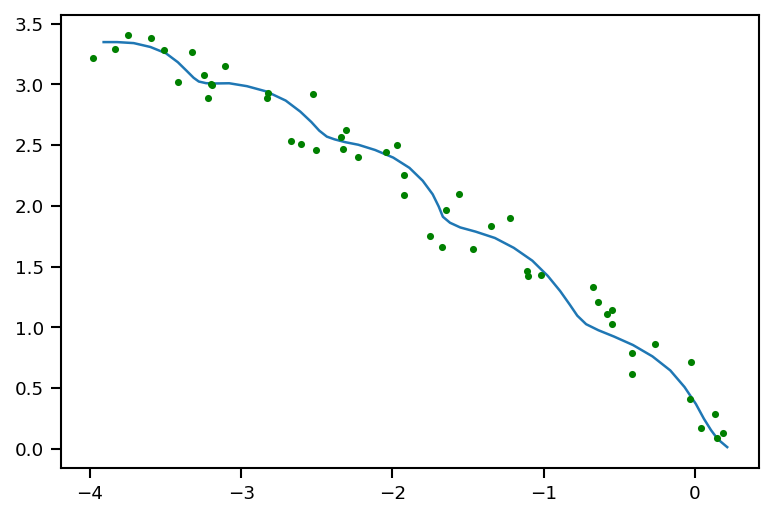

In [4]:
fig, ax = plt.subplots(dpi=150)
ax.plot(true_trajectory[:, 0], true_trajectory[:, 1], '-')
ax.plot(observations[:, 0], observations[:, 1], 'g.')

In [ ]:
y_labels = ['$x_1$', '$x_2$', '$x_3$', '$x_4$']

res_x = 1024
res_y = 768
dpi = 150
w_in = res_x / dpi
h_in = res_y / dpi
fig, ax = plt.subplots(4, 1, dpi=dpi)
fig.set_size_inches(w_in, h_in)

for j in range(4):
    ax[j].set_ylabel(y_labels[j])
ax[-1].set_xlabel('$t$ (time)')

for n in range(1, num_steps):
    for j in range(4):
        ax[j].plot(times[:n+1], true_trajectory[:n+1, j], 'b.-')
        if j < 2:
            ax[j].plot(times[1:n+1], observations[:n, j], 'go')

## Questions

+ Rerun the code a couple of times to observe different trajectories.
+ Double the process noise variance $\sigma_q^2$. What happens?
+ Double the measurement noise variance $\sigma_r^2$. What happens?
+ Zero-out the control vector $\mathbf{u}_{0:n-1}$. What happens?